In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal , Uniform , HalfCauchy
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import NUTS, MCMC
from pyro.optim import Adam
#from TaylorF2 import TaylorF2
from TaylorF2_hack import TaylorF2

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

%matplotlib inline

In [2]:
n_points = 200
Mf_max = 1.0/(6**(3.0/2.0) * np.pi) # cut at ISCO
Mf_array = np.linspace(1e-3, Mf_max, n_points) # Geometric frequency
Mf0 = 0.01
A0 =1.

In [8]:
m1 = torch.tensor(1.5 , dtype = torch.float)
m2 = torch.tensor(1. ,dtype = torch.float )
chi1 = torch.tensor(0 , dtype = torch.float)
chi2 = torch.tensor(0. ,dtype = torch.float)
params = [m1 , m2 , chi1 , chi2]

In [9]:
pn = TaylorF2(*params)
data = pn.compute_strain(Mf_array , Mf0 , A0 )
data = torch.tensor(data, dtype = torch.float)
noise = torch.randn((len(data),) , dtype = torch.float)
data = data + noise 

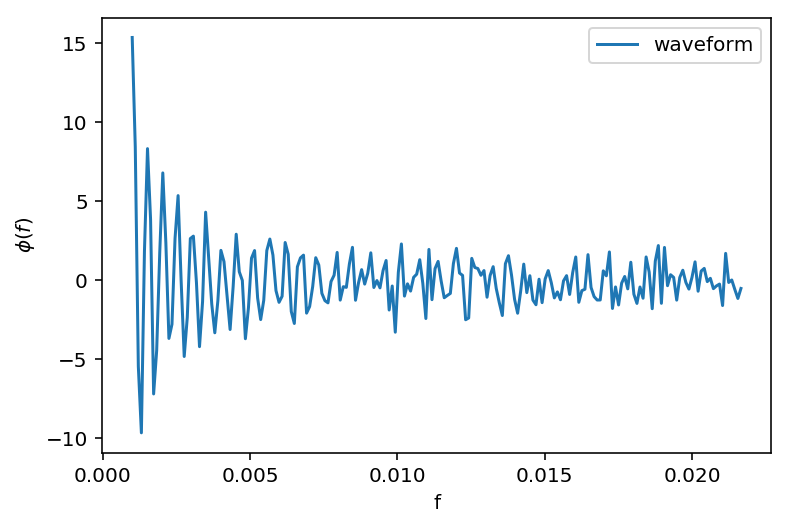

In [10]:
plt.figure()
plt.plot(Mf_array , data.numpy() , label = 'waveform')
plt.xlabel('f')
plt.ylabel(r'$\phi(f)$')
plt.legend()
plt.show()

In [11]:
def model(data):
    m1_prior = pyro.sample("m1", Uniform(low = torch.tensor(1.), high=torch.tensor(3.)))
    m2_prior = pyro.sample("m2", Uniform(low = torch.tensor(0.1), high=torch.tensor(1.)))
    chi1_prior = pyro.sample('chi1' , Uniform(low = torch.tensor(-0.1), high = torch.tensor(0.1)))
    chi2_prior = pyro.sample('chi2' ,Uniform(low = torch.tensor(-0.1), high = torch.tensor(0.1)))
    s2_prior = pyro.sample("variance", HalfCauchy(loc=torch.zeros(1), scale=torch.ones(1)))
    params = [m1_prior , m2_prior , chi1_prior , chi2_prior]
    pn = TaylorF2(*params)
    phase = pn.compute_phasing(Mf_array , Mf0)
    phase = torch.tensor(phase, dtype = torch.float)
    likelihood = pyro.sample("yhat", Normal(loc = phase, scale= 1), obs=data)
    return likelihood

In [12]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=50).run(data)

/Users/Rhys/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Rhys/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


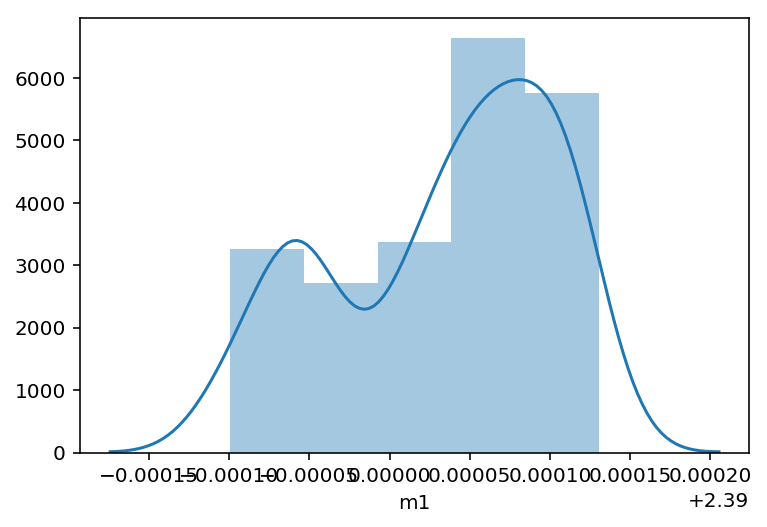

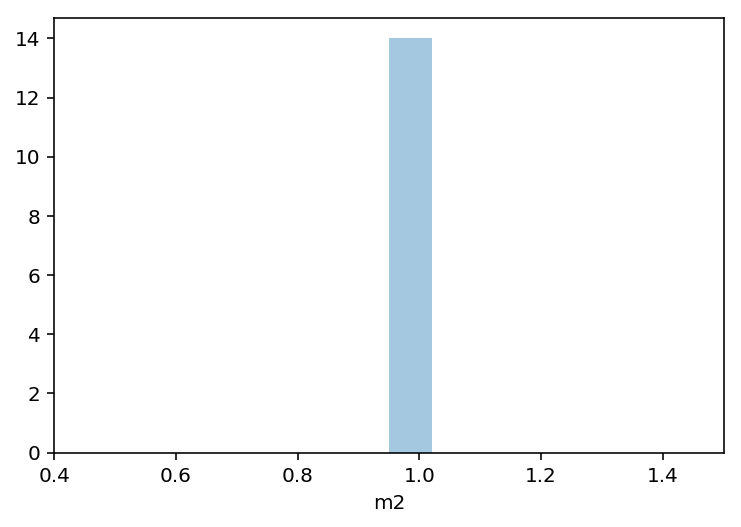

In [13]:
m1_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "m1").get_samples_and_weights()[0]
m2_posterior = pyro.infer.EmpiricalMarginal(mcmc_run, "m2").get_samples_and_weights()[0]
plt.figure()
figa = sns.distplot(m1_posterior)
figa.set(xlabel = 'm1')
plt.figure()
figb = sns.distplot(m2_posterior)
figb.set(xlabel = 'm2')
plt.show()